# Multi-Modal Feature Fusion (QCNN + LiDAR + IMU)

In [5]:
import os, sys, math
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
sys.path.append("/home/gurman_preet_526_gmail_com/lusnar_slam/src")
from lusnar_dataset import LuSNARDataset
plt.rcParams["figure.dpi"] = 120

In [6]:
root = Path("/home/gurman_preet_526_gmail_com/lusnar_slam")
res_qcnn = root / "results_qcnn"
res_icp = root / "results_icp"
t_gt_q = np.load(res_qcnn / "t_gt.npy")
t_cam = np.load(res_qcnn / "t_cam_qcnn.npy")
t_gt_l = np.load(res_icp / "t_gt.npy")
t_lidar = np.load(res_icp / "t_lidar.npy")
fitness_arr = np.load(res_icp / "fitness.npy")
rmse_arr = np.load(res_icp / "rmse_icp_points.npy")
N = min(t_gt_q.shape[0], t_gt_l.shape[0], t_cam.shape[0], t_lidar.shape[0], fitness_arr.shape[0], rmse_arr.shape[0])
t_gt = t_gt_q[:N]
t_cam = t_cam[:N]
t_lidar = t_lidar[:N]
fitness_arr = fitness_arr[:N]
rmse_arr = rmse_arr[:N]
print("Frames:", N)

Frames: 600


In [7]:
DATA_ROOT = root / "datasets" / "Moon_1"
ds = LuSNARDataset(DATA_ROOT)
imu = ds.imu.astype(np.float64)
imu_ts = imu[:, 0].astype(np.int64)
imu_data = imu[:, 1:7].astype(np.float32)
color_ts = ds.color_ts.astype(np.int64)[:N]
def get_imu_for_ts(ts_ns):
    idx = np.searchsorted(imu_ts, ts_ns)
    if idx <= 0:
        j = 0
    elif idx >= len(imu_ts):
        j = len(imu_ts) - 1
    else:
        before = imu_ts[idx - 1]
        after = imu_ts[idx]
        j = idx if abs(after - ts_ns) < abs(ts_ns - before) else idx - 1
    return imu_data[j]
imu_arr = np.stack([get_imu_for_ts(int(ts)) for ts in color_ts], axis=0)
print("IMU array:", imu_arr.shape)

[LuSNAR] Loaded 1094 frames.
IMU array: (600, 6)


feat_all shape: (600, 14)


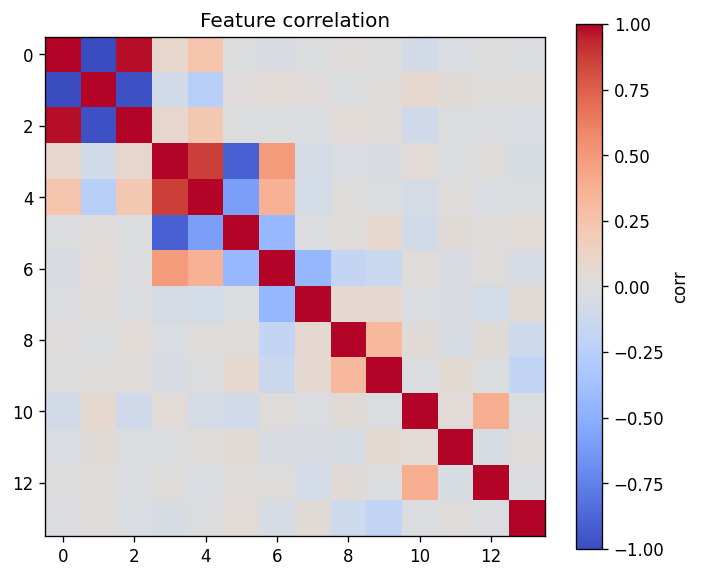

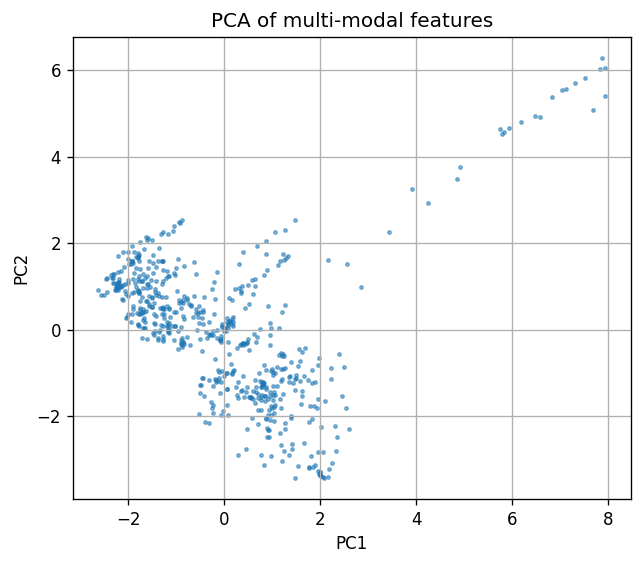

In [8]:
feat_list = [
    t_cam.astype(np.float32),
    t_lidar.astype(np.float32),
    fitness_arr[:, None].astype(np.float32),
    rmse_arr[:, None].astype(np.float32),
    imu_arr.astype(np.float32)
]
feat_all = np.concatenate(feat_list, axis=1)
N_feat, F = feat_all.shape
feat_mean = feat_all.mean(axis=0, keepdims=True)
feat_std = feat_all.std(axis=0, keepdims=True) + 1e-6
feat_all_norm = (feat_all - feat_mean) / feat_std
print("feat_all shape:", feat_all.shape)
corr = np.corrcoef(feat_all.T)
plt.figure(figsize=(6,5))
plt.imshow(corr, cmap="coolwarm", vmin=-1, vmax=1)
plt.colorbar(label="corr")
plt.title("Feature correlation")
plt.tight_layout()
plt.show()
pca = PCA(n_components=2)
feat_pca = pca.fit_transform(feat_all_norm)
plt.figure(figsize=(6,5))
plt.scatter(feat_pca[:,0], feat_pca[:,1], s=4, alpha=0.5)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA of multi-modal features")
plt.grid(True)
plt.show()

In [9]:
out_dir = root / "results_features"
out_dir.mkdir(parents=True, exist_ok=True)
np.savez(out_dir / "features_mm.npz",
         feat_all_norm=feat_all_norm,
         feat_mean=feat_mean,
         feat_std=feat_std,
         t_gt=t_gt,
         t_cam=t_cam,
         t_lidar=t_lidar,
         fitness_arr=fitness_arr,
         rmse_arr=rmse_arr,
         imu_arr=imu_arr,
         N=N)
print("Saved to", out_dir)

Saved to /home/gurman_preet_526_gmail_com/lusnar_slam/results_features
